# Deep GP Unsupervised Learning

## Zhenwen Dai and Neil D. Lawrence

This notebook explores the deep Gaussian processes' capacity to perform unsupervised learning. We will look at a sub-sample of the MNIST digit data set.

This notebook depends on [GPy](https://github.com/SheffieldML/GPy) and [PyDeepGP](https://github.com/SheffieldML/PyDeepGP). These libraries can be installed via pip:
```
pip install GPy
pip install git+https://github.com/SheffieldML/PyDeepGP.git
```

In [16]:
import deepgp
import GPy
import numpy as np
%matplotlib inline
from pylab import *
from IPython.display import display

In [17]:
# Visualization Utility Functions
def ax_default(fignum, ax):
    if ax is None:
        fig = figure(fignum)
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure
    return fig, ax

def meanplot(x, mu, color='#3300FF', ax=None, fignum=None, linewidth=2,**kw):
    _, axes = ax_default(fignum, ax)
    return axes.plot(x,mu,color=color,linewidth=linewidth,**kw)

def gpplot(x, mu, lower, upper, edgecol='#3300FF', fillcol='#33CCFF', ax=None, fignum=None, **kwargs):
    _, axes = ax_default(fignum, ax)

    mu = mu.flatten()
    x = x.flatten()
    lower = lower.flatten()
    upper = upper.flatten()

    plots = []

    #here's the mean
    plots.append(meanplot(x, mu, edgecol, axes))

    #here's the box
    kwargs['linewidth']=0.5
    if not 'alpha' in kwargs.keys():
        kwargs['alpha'] = 0.3
    plots.append(axes.fill(np.hstack((x,x[::-1])),np.hstack((upper,lower[::-1])),color=fillcol,**kwargs))

    #this is the edge:
    plots.append(meanplot(x, upper,color=edgecol,linewidth=0.2,ax=axes))
    plots.append(meanplot(x, lower,color=edgecol,linewidth=0.2,ax=axes))

    return plots

First load in the MNIST data set from scikit learn. This can take a little while because it's large to download.

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [ ]:
Sub-sample the dataset to make the training faster.

In [4]:
np.random.seed(0)
digits = [0,1,2,3,4]
N_per_digit = 100
Y = []
labels = []
for d in digits:
    imgs = mnist['data'][mnist['target']==d]
    Y.append(imgs[np.random.permutation(imgs.shape[0])][:N_per_digit])
    labels.append(np.ones(N_per_digit)*d)
Y = np.vstack(Y).astype(np.float64)
labels = np.hstack(labels)
Y /= 255.

### Fit a Deep GP

We're going to fit a Deep Gaussian process model to the MNIST data with two hidden layers. Each of the two Gaussian processes (one from the first hidden layer to the second, one from the second hidden layer to the data) has an exponentiated quadratic covariance.

In [ ]:
m = deepgp.DeepGP([Y.shape[1],5,2],
                  Y,
                  kernels=[GPy.kern.RBF(5,ARD=True), GPy.kern.RBF(2,ARD=False)], 
                  num_inducing=50, back_constraint=False, 
                  encoder_dims=[[200],[200]])

Now we initialize the observation variance of the model to be 1% of the data variance, and fix the scale parameter on the covariance functions in the hidden layers.

In [21]:
m.obslayer.likelihood.variance[:] = Y.var()*0.01
m.obslayer.rbf.variance = Y.var()
for layer in m.layers:
    layer.kern.variance.fix(warning=False)
    layer.likelihood.variance.fix(warning=False)
display(m)

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(50, 5)",,
obslayer.rbf.variance,0.0961532997497,+ve fixed,
obslayer.rbf.lengthscale,"(5,)",+ve,
obslayer.Gaussian_noise.variance,0.000961532997497,+ve fixed,
obslayer.Kuu_var,"(50,)",+ve,
obslayer.latent space.mean,"(500, 5)",,
obslayer.latent space.variance,"(500, 5)",+ve,
layer_1.inducing inputs,"(50, 2)",,
layer_1.rbf.variance,0.872244462881,+ve fixed,
layer_1.rbf.lengthscale,1.3307582617,+ve,


Now we optimize for a hunderd iterations the constrained model. 

In [22]:
m.optimize(messages=1,max_iters=100)

before firstly unconstraining the variance of the kernels, and then secondly unconstraining the variance of the outputs. Keeping the output variance fixed at the start ensures that trivial solution local optima, that ignore the data and minimize the KL divergence between the prior density and the posterior approximation, are less likely to be found.

In [23]:
for layer in m.layers:
    layer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=1,max_iters=100)

In [24]:
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=1,max_iters=1000)

In [26]:
display(m)

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(50, 5)",,
obslayer.rbf.variance,0.228721535456,+ve,
obslayer.rbf.lengthscale,"(5,)",+ve,
obslayer.Gaussian_noise.variance,0.0256705785174,+ve,
obslayer.Kuu_var,"(50,)",+ve,
obslayer.latent space.mean,"(500, 5)",,
obslayer.latent space.variance,"(500, 5)",+ve,
layer_1.inducing inputs,"(50, 2)",,
layer_1.rbf.variance,5.47244512191,+ve,
layer_1.rbf.lengthscale,0.676639298156,+ve,


### Visualize the latent space of the top layer

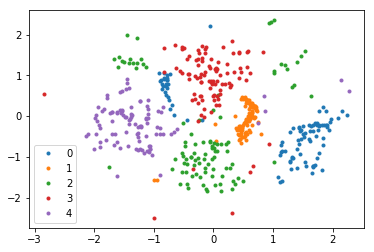

In [27]:
for d in digits:
    plot(m.layer_1.X.mean[labels==d,0],m.layer_1.X.mean[labels==d,1],'.',label=str(d))
legend()

### Visualize the latent space of the intermediate layer

In [28]:
m.obslayer.kern.lengthscale

index,deepgp.obslayer.rbf.lengthscale,constraints,priors
[0],4.29167835,+ve,
[1],5.00094295,+ve,
[2],6.33955092,+ve,
[3],6.85580918,+ve,
[4],5.78189414,+ve,


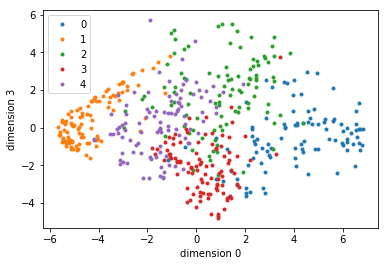

In [48]:
dims=[0, 3]
for d in digits:
    plot(m.obslayer.X.mean[labels==d,dims[0]],
         m.obslayer.X.mean[labels==d,dims[1]],
         '.', label=str(d))
legend()
xlabel('dimension ' + str(dims[0]))
ylabel('dimension ' + str(dims[1]))

### Generate Test Examples

Now we can take a look at a sample from the model, by drawing a Gaussian random sample in the latent space and propagating it through the model. 

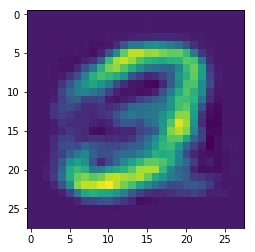

In [50]:
yt = m.predict(np.random.randn(1,2))
imshow(yt[0].reshape(28,28))